In [36]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint

**Using SCARA manipulator**

Some of the below code is taken from my midsem submission

In [37]:
class scara():
  def __init__(self):
    
    self.a1=0.25
    self.a2=0.25
    self.h=0.25
    self.tags=["Theta1","Theta2","D"]
    self.m1=1
    self.m2=1
  
  def setpos(self,arr):
    self.x=arr[0]
    self.y=arr[1]
    self.z=arr[2]
    self.invkine()

# Inverse Kinematics
  def invkine(self):
    r= ((self.x**2+self.y**2-self.a1**2-self.a2**2)/(2*self.a1*self.a2))
    self.theta2 = np.arctan2(((1-r**2)**0.5),r)
    self.theta1 = np.arctan2(self.y,self.x)-np.arctan2(self.a2*np.sin(self.theta2),(self.a1+self.a2*np.cos(self.theta2)))

    self.d3=self.h-self.z

# Forward Kinematics
  def forward(self,theta1,theta2):
    x1=self.a1*np.cos(theta1)+self.a2*np.cos(theta1+theta2)
    y1=self.a1*np.sin(theta1)+self.a2*np.sin(theta1+theta2)

    return [x1,y1]

  def verify(self,arr):
    self.setpos(arr)
    print(f"Original Co-ordinates:- {[self.x,self.y,self.z]}\n")
    print(f"Verified from code :- {self.forward()}\n")
    print(f"Joint parameters: \n theta1: {self.theta1} rad \n theta2: {self.theta2} rad \n d3: {self.d3} m \n\n")

In [38]:
def trajectory(A,B,tf):
  I=scara()
  I.setpos(A)
  F=scara()
  F.setpos(B)
  t0=0
  #Initial and final conditions matrices
  M=np.matrix([[1,t0,t0**2,t0**3],[0,1,2*t0,3*(t0**3)],[1,tf,tf**2,tf**3],[0,1,2*tf,3*(tf**3)]])
  Q1=np.matrix([[I.theta1,0,F.theta1,0]]).T
  Q2=np.matrix([[I.theta2,0,F.theta2,0]]).T
  D=np.matrix([[I.d3,0,F.d3,0]]).T
  # Coefficient matrices
  a1=np.matmul(np.linalg.inv(M),Q1)
  a2=np.matmul(np.linalg.inv(M),Q2)
  a3=np.matmul(np.linalg.inv(M),D)

  P=[]
  V=[]
  A=[]
  t=[]
#a1
  p=[]
  v=[]
  a=[]

  while (t0<=tf) :
    p.append(a1[0,0]+a1[1,0]*t0+a1[2,0]*(t0**2)+a1[3,0]*(t0**3))
    v.append(a1[1,0]+2*a1[2,0]*t0+3*a1[3,0]*(t0**2))
    a.append(2*a1[2,0]+6*a1[3,0]*(t0))
    t.append(t0)
    t0+=0.01
  P.append(p)
  V.append(v)
  A.append(a)
  t0=0
#a2
  p=[]
  v=[]
  a=[]
  while (t0<=tf) :
    p.append(a2[0,0]+a2[1,0]*t0+a2[2,0]*(t0**2)+a2[3,0]*(t0**3))
    v.append(a2[1,0]+2*a2[2,0]*t0+3*a2[3,0]*(t0**2))
    a.append(2*a2[2,0]+6*a2[3,0]*(t0))
    t0+=0.01
  P.append(p)
  V.append(v)
  A.append(a)
  t0=0
#a3
  p=[]
  v=[]
  a=[]
  while (t0<=tf) :
    p.append(a3[0,0]+a3[1,0]*t0+a3[2,0]*(t0**2)+a3[3,0]*(t0**3))
    v.append(a3[1,0]+2*a3[2,0]*t0+3*a3[3,0]*(t0**2))
    a.append(2*a3[2,0]+6*a3[3,0]*(t0))
    t0+=0.01
  P.append(p)
  V.append(v)
  A.append(a)
  t0=0

  return P,V,A,t,I.tags


In [39]:
def trajectory_plot(P,V,A,t,tags):
  #Position
  i=0 
  for item in P:
    plt.plot(t,item)
    plt.title(f"Position {tags[i]} Vs Time")
    plt.xlabel("Time")
    plt.ylabel(f"Position {tags[i]}")
    i+=1
    plt.grid()
    plt.show()

  #Velocity
  i=0
  for item in V:
    plt.plot(t,item)
    plt.title(f"Velocity {tags[i]} Vs Time")
    plt.xlabel("Time")
    plt.ylabel(f"Velocity {tags[i]}")
    i+=1
    plt.grid()
    plt.show()
  #Acceleration
  i=0
  for item in A:
    plt.plot(t,item)
    plt.title(f"Acceleration {tags[i]} Vs Time")
    plt.xlabel("Time")
    plt.ylabel(f"Acceleration {tags[i]}")
    i+=1
    plt.grid()
    plt.show()

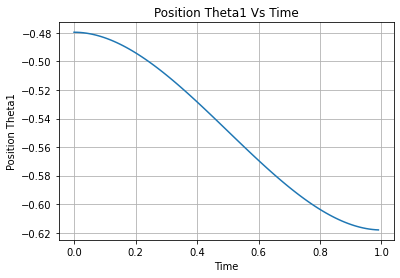

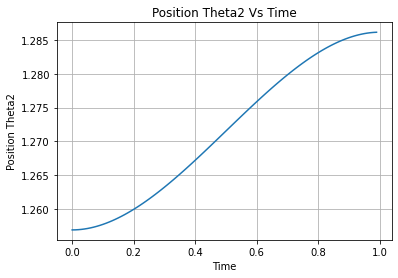

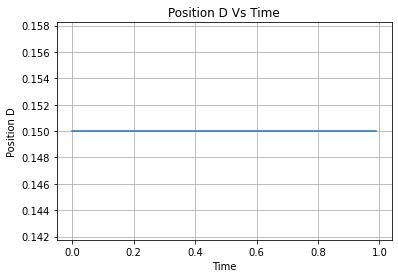

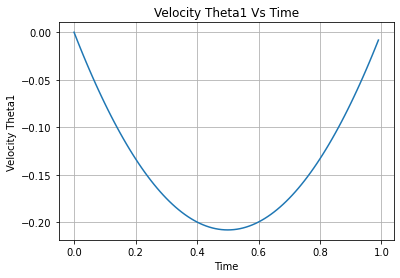

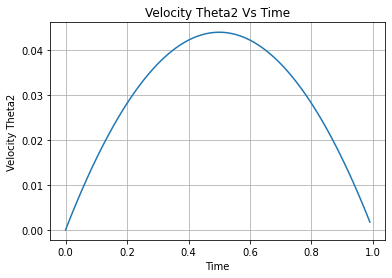

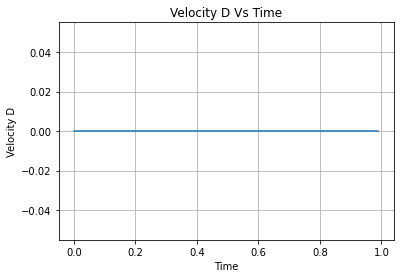

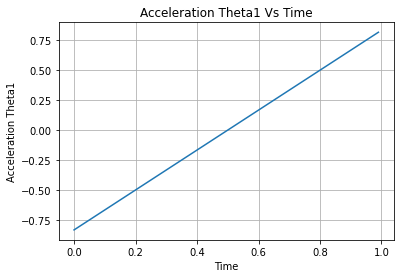

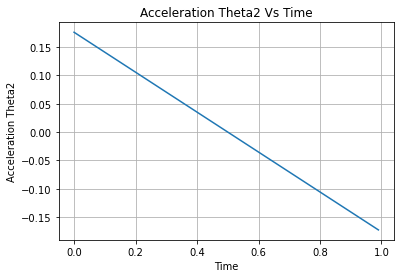

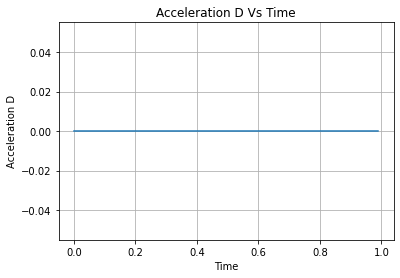

In [40]:
A=[0.4,0.06,0.1]
B=[0.4,0.01,0.1]
P=trajectory(A,B,1)
trajectory_plot(P[0],P[1],P[2],P[3],P[4])

#PD controller
Control System implementation \\
**a.** PD control that might yield a small (but non-zero steady-state error and damping ratio close to 1.


In [41]:
class PDcontroller(scara):
  def __init__(self,kp,kd):
    super().__init__()
    self.kp=kp
    self.kd=kd
    self.ode=self.ode = scipy.integrate.ode(self.func).set_integrator('vode', nsteps = 500 , method = 'bdf')

    self.q1=0
    self.q2=0
    self.q1dot=0
    self.q2dot=0

    self.X=[]
    self.Xorg=[]

    self.Y=[]
    self.Yorg=[]

    self.D1=0
    self.D2=0

    self.preverr1=0
    self.preverr2=0
    

  def func(self,t,y):
    q1=y[0]
    q2=y[1]
    q1dot = y[2]
    q2dot = y[3]

    b=0.3 #Damping coefficient

    # PD controller Equations
    #1
    err1=self.theta1-q1
    self.P1=self.kp*err1
    self.D1+=self.kd*(err1-self.preverr1)*2/0.1

    self.preverr1=err1
    #2
    err2=self.theta2-q2

    self.P2=self.kp*err2
    self.D2+=self.kd*(err2-self.preverr2)*2/0.1

    self.preverr2=err2

    t1=(self.P1+self.D1)
    t2=(self.P2+self.D2)

    #Dynamics equations
    t=np.matrix([[t1],[t2]])

    c=np.matrix([[-4*self.m2*self.a1*self.a2*np.sin(q2)*q2dot, -2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot],[2*self.m2*self.a1*self.a2*np.sin(q2)*q1dot, 0]])
    qdot=np.matrix([q1dot,q2dot]).T
    d11=(self.m1+4*self.m2)*self.a1**2+self.m2*self.a2**2+4*self.m2*self.a1*self.a2*np.cos(q2)
    d12=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.cos(q2)
    d21=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot
    d22=self.m2*self.a2**2
    d=np.matrix([[d11,d12],[d21,d22]])

    #calculating qddot using t and dynamics equaions
    qddot = np.matmul(np.linalg.inv(d),t-np.matmul(c,qdot))

    dydt=[q1dot , q2dot , qddot[0][0]-b*q1dot , qddot[1][0]-b*q2dot]
    
    return dydt


  def step(self, dt):
        state = [self.q1, self.q2, self.q1dot , self.q2dot]

        self.ode.set_initial_value(state, 0)
        newstate = self.ode.integrate(dt)

        self.q1=newstate[0]
        self.q2=newstate[1]

        self.q1dot=newstate[2]
        self.q2dot=newstate[3]

  def update(self,theta1,theta2,dt):
    self.theta1=theta1;
    self.theta2=theta2;
    self.step(dt)
    self.X.append(self.forward(self.q1,self.q2)[0])
    self.Xorg.append(self.forward(self.theta1,self.theta2)[0])

    self.Y.append(self.forward(self.q1,self.q2)[1])
    self.Yorg.append(self.forward(self.theta1,self.theta2)[1])



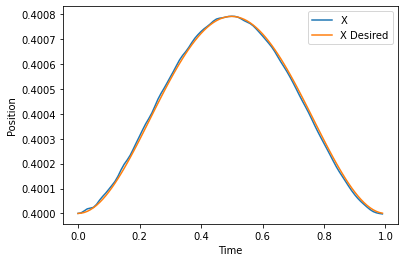

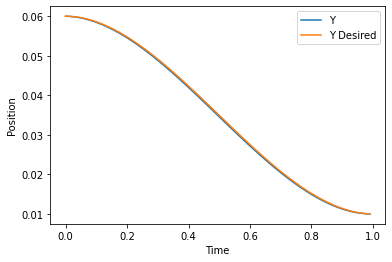

In [42]:
pd=PDcontroller(9,6)
pd.setpos([0.4,0.06,0.1])
pd.q1=pd.theta1
pd.q2=pd.theta2
for i in range(len(P[0][0])):
  pd.update(P[0][0][i],P[0][1][i],0.1)

plt.plot(P[3],pd.X)
plt.plot(P[3],pd.Xorg)
plt.legend(["X","X Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show() 
plt.plot(P[3],pd.Y)
plt.plot(P[3],pd.Yorg)
plt.legend(["Y","Y Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show()

#Feedforward control
**b.** Same PD control along with a feedforward control using motor dynamic (equation 7.6.6 in the textbook).

In [43]:
class PDfeedforward(scara):
  def __init__(self,kp,kd):
    super().__init__()
    self.kp=kp
    self.kd=kd
    self.ode=self.ode = scipy.integrate.ode(self.func).set_integrator('vode', nsteps = 500 , method = 'bdf')

    self.q1=0
    self.q2=0
    self.q1dot=0
    self.q2dot=0

    self.qdot1=0
    self.qdot2=0
    self.qddot1=0
    self.qddot2=0

    self.X=[]
    self.Xorg=[]

    self.Y=[]
    self.Yorg=[]

    self.D1=0
    self.D2=0

    self.preverr1=0
    self.preverr2=0
    
    self.jeff1=0.2
    self.beff1=0.2
    
    self.jeff2=0.1
    self.beff2=0.1
  def func(self,t,y):
    q1=y[0]
    q2=y[1]
    q1dot = y[2]
    q2dot = y[3]

    b=0.3 #Damping coefficient

    # PD controller Equations
    #1
    err1=self.theta1-q1
    self.P1=self.kp*err1
    self.D1+=self.kd*(err1-self.preverr1)*2/0.1
    self.f1=self.jeff1*self.qddot1+self.beff1*self.qdot1

    self.preverr1=err1
    #2
    err2=self.theta2-q2

    self.P2=self.kp*err2
    self.D2+=self.kd*(err2-self.preverr2)*2/0.1
    self.f2=self.jeff2*self.qddot2+self.beff2*self.qdot2
    self.preverr2=err2

    t1=(self.P1+self.D1+self.f1)
    t2=(self.P2+self.D2+self.f2)

    #Dynamics equations
    t=np.matrix([[t1],[t2]])

    c=np.matrix([[-4*self.m2*self.a1*self.a2*np.sin(q2)*q2dot, -2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot],[2*self.m2*self.a1*self.a2*np.sin(q2)*q1dot, 0]])
    qdot=np.matrix([q1dot,q2dot]).T
    d11=(self.m1+4*self.m2)*self.a1**2+self.m2*self.a2**2+4*self.m2*self.a1*self.a2*np.cos(q2)
    d12=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.cos(q2)
    d21=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot
    d22=self.m2*self.a2**2
    d=np.matrix([[d11,d12],[d21,d22]])

    #calculating qddot using t and dynamics equaions
    qddot = np.matmul(np.linalg.inv(d),t-np.matmul(c,qdot))

    dydt=[q1dot , q2dot , qddot[0][0]-b*q1dot , qddot[1][0]-b*q2dot]
    
    return dydt


  def step(self, dt):
        state = [self.q1, self.q2, self.q1dot , self.q2dot]

        self.ode.set_initial_value(state, 0)
        newstate = self.ode.integrate(dt)

        self.q1=newstate[0]
        self.q2=newstate[1]

        self.q1dot=newstate[2]
        self.q2dot=newstate[3]

  def update(self,theta1,theta2,qdot1,qdot2,qddot1,qddot2,dt):
    self.theta1=theta1
    self.theta2=theta2
    self.qdot1=qdot1
    self.qdot2=qdot2
    self.qddot1=qddot1
    self.qddot2=qddot2
    self.step(dt)
    self.X.append(self.forward(self.q1,self.q2)[0])
    self.Xorg.append(self.forward(self.theta1,self.theta2)[0])

    self.Y.append(self.forward(self.q1,self.q2)[1])
    self.Yorg.append(self.forward(self.theta1,self.theta2)[1])

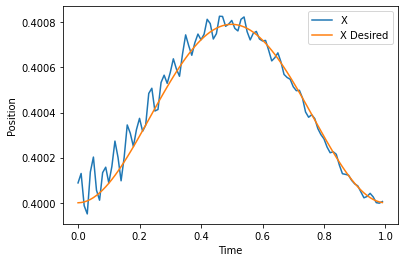

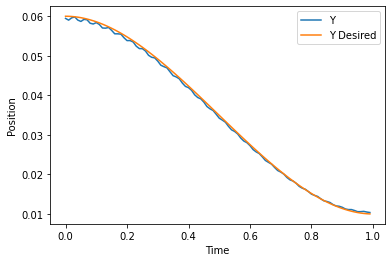

In [44]:
pd=PDfeedforward(9,6)
pd.setpos([0.4,0.06,0.1])
pd.q1=pd.theta1
pd.q2=pd.theta2
for i in range(len(P[0][0])):
  pd.update(P[0][0][i],P[0][1][i],P[1][0][i],P[1][1][i],P[2][0][i],P[2][1][i],0.1)

plt.plot(P[3],pd.X)
plt.plot(P[3],pd.Xorg)
plt.legend(["X","X Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show() 
plt.plot(P[3],pd.Y)
plt.plot(P[3],pd.Yorg)
plt.legend(["Y","Y Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show()

**c.** Same PD control along with a feed forward disturbance cancellation using computed torque method (equation 7.6.9 in the textbook).

In [45]:
class PDfeedforwardComputed(scara):
  def __init__(self,kp,kd):
    super().__init__()
    self.kp=kp
    self.kd=kd
    self.ode=self.ode = scipy.integrate.ode(self.func).set_integrator('vode', nsteps = 500 , method = 'bdf')

    self.q1=0
    self.q2=0
    self.q1dot=0
    self.q2dot=0

    self.qdot1=0
    self.qdot2=0
    self.qddot1=0
    self.qddot2=0

    self.X=[]
    self.Xorg=[]

    self.Y=[]
    self.Yorg=[]

    self.D1=0
    self.D2=0

    self.preverr1=0
    self.preverr2=0
    
    self.jeff1=0.2
    self.beff1=0.2
    
    self.jeff2=0.1
    self.beff2=0.1
  def func(self,t,y):
    q1=y[0]
    q2=y[1]
    q1dot = y[2]
    q2dot = y[3]

    b=0.3 #Damping coefficient

    # PD controller Equations
    #1
    err1=self.theta1-q1
    self.P1=self.kp*err1
    self.D1+=self.kd*(err1-self.preverr1)*2/0.1
    self.f1=self.jeff1*self.qddot1+self.beff1*self.qdot1

    self.preverr1=err1
    #2
    err2=self.theta2-q2

    self.P2=self.kp*err2
    self.D2+=self.kd*(err2-self.preverr2)*2/0.1
    self.f2=self.jeff2*self.qddot2+self.beff2*self.qdot2
    self.preverr2=err2

    t1=(self.P1+self.D1+self.f1+self.torq[0]+self.disturb)
    t2=(self.P2+self.D2+self.f2+self.torq[1]+self.disturb)

    #Dynamics equations
    t=np.matrix([[t1],[t2]])

    c=np.matrix([[-4*self.m2*self.a1*self.a2*np.sin(q2)*q2dot, -2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot],[2*self.m2*self.a1*self.a2*np.sin(q2)*q1dot, 0]])
    qdot=np.matrix([q1dot,q2dot]).T
    d11=(self.m1+4*self.m2)*self.a1**2+self.m2*self.a2**2+4*self.m2*self.a1*self.a2*np.cos(q2)
    d12=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.cos(q2)
    d21=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.sin(q2)*q2dot
    d22=self.m2*self.a2**2
    d=np.matrix([[d11,d12],[d21,d22]])

    #calculating qddot using t and dynamics equaions
    qddot = np.matmul(np.linalg.inv(d),t-np.matmul(c,qdot))

    dydt=[q1dot , q2dot , qddot[0][0]-b*q1dot , qddot[1][0]-b*q2dot]
    
    return dydt


  def step(self, dt):
        state = [self.q1, self.q2, self.q1dot , self.q2dot]

        self.ode.set_initial_value(state, 0)
        newstate = self.ode.integrate(dt)

        self.q1=newstate[0]
        self.q2=newstate[1]

        self.q1dot=newstate[2]
        self.q2dot=newstate[3]

  def update(self,theta1,theta2,qdot1,qdot2,qddot1,qddot2,dt,disturb):
    self.theta1=theta1
    self.theta2=theta2
    self.qdot1=qdot1
    self.qdot2=qdot2
    self.qddot1=qddot1
    self.qddot2=qddot2
    self.torq=self.torque()
    self.disturb=disturb
    self.step(dt)
    self.X.append(self.forward(self.q1,self.q2)[0])
    self.Xorg.append(self.forward(self.theta1,self.theta2)[0])

    self.Y.append(self.forward(self.q1,self.q2)[1])
    self.Yorg.append(self.forward(self.theta1,self.theta2)[1])

  def torque(self):
    c=np.matrix([[-4*self.m2*self.a1*self.a2*np.sin(self.theta2)*self.qdot2, -2*self.m2*self.a1*self.a2*np.sin(self.theta2)*self.qdot2],[2*self.m2*self.a1*self.a2*np.sin(self.theta2)*self.qdot1, 0]])
    qdot=np.matrix([self.qdot1,self.qdot2]).T
    d11=(self.m1+4*self.m2)*self.a1**2+self.m2*self.a2**2+4*self.m2*self.a1*self.a2*np.cos(self.theta2)
    d12=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.cos(self.theta2)
    d21=self.m2*self.a2**2+2*self.m2*self.a1*self.a2*np.sin(self.theta2)*self.qdot2
    d22=self.m2*self.a2**2
    d=np.matrix([[d11,d12],[d21,d22]])

    qddot=np.matrix([self.qddot1,self.qddot2]).T
    t=np.matmul(d,qddot)+np.matmul(c,qdot)
    return t.item(0),t.item(1)



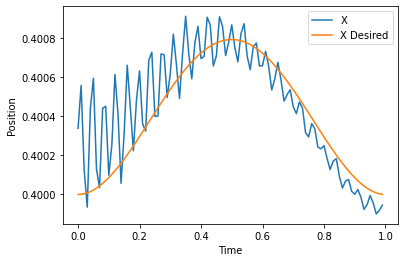

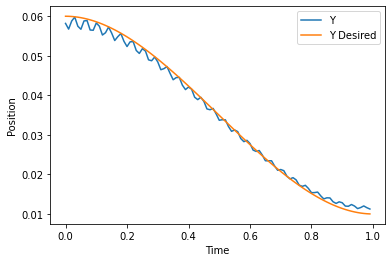

In [46]:
pd=PDfeedforwardComputed(9,6)
pd.setpos([0.4,0.06,0.1])
pd.q1=pd.theta1
pd.q2=pd.theta2
for i in range(len(P[0][0])):
  pd.update(P[0][0][i],P[0][1][i],P[1][0][i],P[1][1][i],P[2][0][i],P[2][1][i],0.1,0)

plt.plot(P[3],pd.X)
plt.plot(P[3],pd.Xorg)
plt.legend(["X","X Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show() 
plt.plot(P[3],pd.Y)
plt.plot(P[3],pd.Yorg)
plt.legend(["Y","Y Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


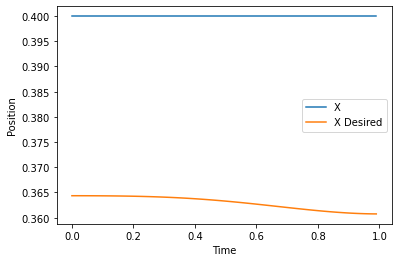

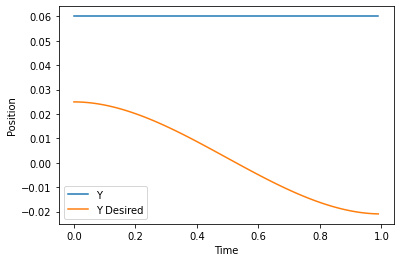

In [47]:
pd=PDfeedforwardComputed(9,6)
pd.a2=0.8*pd.a2
pd.setpos([0.4,0.06,0.1])
pd.q1=pd.theta1
pd.q2=pd.theta2
for i in range(len(P[0][0])):
  pd.update(P[0][0][i],P[0][1][i],P[1][0][i],P[1][1][i],P[2][0][i],P[2][1][i],0.1,0)

plt.plot(P[3],pd.X)
plt.plot(P[3],pd.Xorg)
plt.legend(["X","X Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show() 
plt.plot(P[3],pd.Y)
plt.plot(P[3],pd.Yorg)
plt.legend(["Y","Y Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show()

**Impulsive Disturbance**

/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


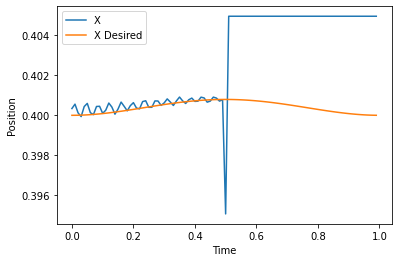

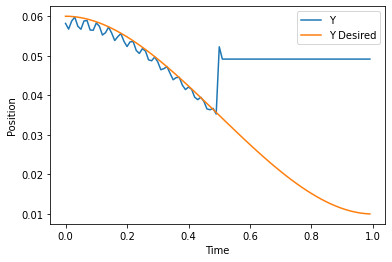

In [48]:
d=[]
for i in range(len(P[0][0])):
  d.append(0)

d[50]=4

pd=PDfeedforwardComputed(9,6)
pd.setpos([0.4,0.06,0.1])
pd.q1=pd.theta1
pd.q2=pd.theta2
for i in range(len(P[0][0])):
  pd.update(P[0][0][i],P[0][1][i],P[1][0][i],P[1][1][i],P[2][0][i],P[2][1][i],0.1,d[i])

plt.plot(P[3],pd.X)
plt.plot(P[3],pd.Xorg)
plt.legend(["X","X Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show() 
plt.plot(P[3],pd.Y)
plt.plot(P[3],pd.Yorg)
plt.legend(["Y","Y Desired"])
plt.xlabel("Time")
plt.ylabel(f"Position")
plt.show()